## Load packages and model

In [1]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\penaf\anaconda3\envs\pert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2" 
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Load and tokenize prompts

In [3]:
df = pd.read_csv("./data/prompts.csv", quotechar='"')
df.head(-1)

,id,prompt
0,1,Who discovered penicillin?
1,2,When was the Eiffel Tower built?
2,3,What is the capital of Australia?
3,4,How tall is Mount Everest?
4,5,Who painted the Mona Lisa?
...,...,...
94,95,"Finish: 'In the morning, I always…'"
95,96,Give an example of a metaphor.
96,97,List two programming languages.
97,98,Write a haiku about winter.


In [4]:
tokenized_prompts = []

for prompt in df['prompt']:
    tokenized_prompts.append(tokenizer.encode_plus(prompt, return_tensors="pt"))

tokenized_prompts[0]

{'input_ids': tensor([[ 8241,  5071,  3112,   291, 32672,    30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

## Define Pertrubing methods

1. Zeroing High-Frequency
2. Zeroing Low-Frequency

In [5]:
def wavelet_perturb(embeddings_tensor, wavelet='haar'):
    """
    Applies discrete wavelet transform per token embedding vector,
    zeros out high-frequency coefficients, and reconstructs embeddings.
    """
    emb_np = embeddings_tensor.squeeze(0).cpu().numpy()  # [seq_len, embed_dim]
    perturbed_np = np.zeros_like(emb_np)

    for i in range(emb_np.shape[0]):  # for each token vector
        coeffs = pywt.dwt(emb_np[i, :], wavelet)
        cA, cD = coeffs
        # Zero out high frequency coefficients
        cD[:] = 0
        # Reconstruct embedding
        perturbed_np[i, :] = pywt.idwt(cA, cD, wavelet)

    perturbed_tensor = torch.tensor(perturbed_np, dtype=torch.float32).unsqueeze(0)
    return perturbed_tensor

def wavelet_perturb2(embeddings_tensor, wavelet='haar'):
    """
    Applies discrete wavelet transform per token embedding vector,
    zeros out low-frequency coefficients, and reconstructs embeddings.
    """
    emb_np = embeddings_tensor.squeeze(0).cpu().numpy()  # [seq_len, embed_dim]
    perturbed_np = np.zeros_like(emb_np)

    for i in range(emb_np.shape[0]):  # for each token vector
        coeffs = pywt.dwt(emb_np[i, :], wavelet)
        cA, cD = coeffs
        # Zero out high frequency coefficients
        cA[:] = 0
        # Reconstruct embedding
        perturbed_np[i, :] = pywt.idwt(cA, cD, wavelet)

    perturbed_tensor = torch.tensor(perturbed_np, dtype=torch.float32).unsqueeze(0)
    return perturbed_tensor

## Embed tokenized inputs

In [6]:
embeddings = []

with torch.no_grad():
    for prompt in tokenized_prompts:
        input_ids = prompt['input_ids']
        embedding = model.transformer.wte(input_ids)
        embeddings.append(embedding.cpu().numpy())

embeddings[1].shape

(1, 9, 768)

## Define pertrubed and original inputs

In [7]:
# Zero out high frequency components
zero_high_freq = []

for emb in embeddings:
    emb_tensor = torch.tensor(emb, dtype=torch.float32)
    perturbed_emb = wavelet_perturb(emb_tensor)
    zero_high_freq.append(perturbed_emb)

# Zero out low frequency components
zero_low_freq = []

for emb in embeddings:
    emb_tensor = torch.tensor(emb, dtype=torch.float32)
    perturbed_emb = wavelet_perturb2(emb_tensor)
    zero_low_freq.append(perturbed_emb)

# Original embeddings
original_embeddings = []

for emb in embeddings:
    original_embeddings.append(torch.tensor(emb, dtype=torch.float32))

print(zero_high_freq[1].shape)
print(zero_low_freq[1].shape)
print(original_embeddings[1].shape)

torch.Size([1, 9, 768])
torch.Size([1, 9, 768])
torch.Size([1, 9, 768])


## Auto-regressive top-k logits

- (x = 5) x auto-regressive tokens to predict
- (k = 10) top-k logits for interpretability

In [9]:
import torch
from concurrent.futures import ThreadPoolExecutor

def _autoregressive_topk_single(model, tokenizer, emb, x, k):
    """
    Helper for one embedding
    """
    topk_predictions = []
    generated_embeds = emb.clone()  # (1, seq_len, hidden_dim)

    with torch.no_grad():
        for _ in range(x):
            outputs = model(inputs_embeds=generated_embeds)  # (1, seq_len, vocab_size)
            next_token_logits = outputs.logits[:, -1, :]     # (1, vocab_size)

            # Top-k
            topk_probs, topk_ids = torch.topk(next_token_logits, k=k, dim=-1)
            topk_tokens = [tokenizer.decode(ids).strip() for ids in topk_ids[0]]
            topk_predictions.append(topk_tokens)

            # Append top-1 token embedding to continue autoregressively
            next_token_id = topk_ids[:, 0].unsqueeze(-1)  # (1,1)
            next_token_embed = model.transformer.wte(next_token_id)  # (1,1,hidden_dim)
            generated_embeds = torch.cat([generated_embeds, next_token_embed], dim=1)

    return topk_predictions


def autoregressive_topk_parallel(model, tokenizer, embeddings_list, x=5, k=10, max_workers=4):
    """
    Run autoregressive top-k in parallel over multiple embeddings.
    """
    all_topk_predictions = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(_autoregressive_topk_single, model, tokenizer, emb, x, k)
            for emb in embeddings_list
        ]
        for future in futures:
            all_topk_predictions.append(future.result())

    return all_topk_predictions

## Extract top-k logits

In [11]:
topk_original = autoregressive_topk_parallel(model, tokenizer, original_embeddings, x=5, k=10)
topk_zero_high = autoregressive_topk_parallel(model, tokenizer, zero_high_freq, x=5, k=10)
topk_zero_low = autoregressive_topk_parallel(model, tokenizer, zero_low_freq, x=5, k=10)

In [14]:
def _autoregressive_wavelet_single(model, emb_orig, emb_low, emb_high, x):
    """
    Helper function for a single prompt: generates logits autoregressively
    for original, low, and high-frequency-zeroed embeddings.
    """
    device = emb_orig.device
    emb_dict = {
        "original": emb_orig.clone(),
        "low":      emb_low.clone(),
        "high":     emb_high.clone()
    }
    variants = ["original", "low", "high"]
    logits_dict = {v: [] for v in variants}

    with torch.no_grad():
        for step in range(x):
            out_dict = {}
            # Forward pass
            for v in variants:
                out = model(inputs_embeds=emb_dict[v]).logits[:, -1, :]  # (1, vocab_size)
                out_dict[v] = out
                logits_dict[v].append(out.cpu())  # store on CPU to save GPU memory

            # Greedy autoregression: append top-1 embedding
            for v in variants:
                next_token_id = torch.argmax(out_dict[v], dim=-1).unsqueeze(-1)
                next_token_embed = model.transformer.wte(next_token_id)
                emb_dict[v] = torch.cat([emb_dict[v], next_token_embed], dim=1)

    return {
        "logits_original": logits_dict["original"],
        "logits_low": logits_dict["low"],
        "logits_high": logits_dict["high"]
    }


def autoregressive_wavelet_perturb_logits_parallel(
    model,
    embeddings_original, embeddings_low, embeddings_high,
    x=5,
    max_workers=4
):
    """
    Parallelized autoregressive logits generation for original + wavelet-perturbed embeddings.

    Args:
        model: transformer LM
        embeddings_original, embeddings_low, embeddings_high:
            lists of N tensors, each (1, seq_len, hidden_dim)
        x: autoregressive steps
        max_workers: number of threads

    Returns:
        results: list of length N (one per prompt), same format as _single
    """
    N = len(embeddings_original)
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
                _autoregressive_wavelet_single,
                model,
                embeddings_original[i].to(next(model.parameters()).device),
                embeddings_low[i].to(next(model.parameters()).device),
                embeddings_high[i].to(next(model.parameters()).device),
                x
            )
            for i in range(N)
        ]

        for future in futures:
            results.append(future.result())

    return results

In [15]:
# Run autoregression
results = autoregressive_wavelet_perturb_logits_parallel(
    model, original_embeddings, zero_low_freq, zero_high_freq, x=5
)

# Work with raw logits → convert to probabilities
prompt_idx, step = 0, 0
logits_orig = results[prompt_idx]["logits_original"][step]  # (1, vocab_size)
logits_low  = results[prompt_idx]["logits_low"][step]
logits_high = results[prompt_idx]["logits_high"][step]

probs_orig = F.softmax(logits_orig, dim=-1)
probs_low  = F.softmax(logits_low, dim=-1)
probs_high = F.softmax(logits_high, dim=-1)

# Top-k tokens (you handle outside the function)
k = 25
topk_indices = torch.topk(probs_orig, k).indices[0].cpu().numpy()
tokens = [tokenizer.decode([i]) for i in topk_indices]

print("Tokens:", tokens)
print("Original probs:", probs_orig[0, topk_indices])
print("Low pert probs:", probs_low[0, topk_indices])
print("High pert probs:", probs_high[0, topk_indices])

Tokens: ['\n', ' It', ' I', ' What', ' Did', ' How', ' Why', ' The', ' We', ' You', ' And', ' Well', ' He', ' No', ' Read', ' That', ' They', ' Is', ' Who', ' A', '\n\n', ' "', ' Yes', ' If', ' Or']
Original probs: tensor([0.1816, 0.0342, 0.0293, 0.0289, 0.0244, 0.0212, 0.0192, 0.0187, 0.0185,
        0.0146, 0.0136, 0.0128, 0.0121, 0.0120, 0.0119, 0.0117, 0.0099, 0.0094,
        0.0080, 0.0078, 0.0071, 0.0070, 0.0067, 0.0065, 0.0065])
Low pert probs: tensor([6.8213e-01, 7.2572e-03, 4.5049e-02, 5.5185e-03, 6.9106e-04, 3.7580e-03,
        2.4154e-03, 1.9824e-02, 2.5032e-03, 2.5048e-03, 5.1704e-03, 6.4399e-04,
        2.0137e-03, 5.6730e-03, 4.0406e-04, 1.2286e-03, 1.4688e-03, 2.0122e-03,
        4.6844e-04, 1.1467e-02, 8.3887e-03, 1.0334e-02, 1.2840e-03, 4.3052e-03,
        1.4775e-03])
High pert probs: tensor([7.1251e-01, 3.4973e-03, 3.7651e-02, 4.6090e-03, 1.2070e-03, 2.0268e-03,
        1.7295e-03, 7.2371e-03, 1.2049e-03, 1.3525e-03, 4.3866e-03, 1.1429e-03,
        1.3302e-03, 3.4341

In [29]:
results[0]

{'logits_original': [tensor([[-128.7082, -127.7682, -130.8658,  ..., -139.6188, -140.3421,
           -126.0497]]),
  tensor([[-241.8227, -236.8442, -240.4642,  ..., -258.9789, -266.9789,
           -238.0917]]),
  tensor([[-111.0598, -104.2848, -108.2935,  ..., -123.9301, -125.8809,
           -114.6389]]),
  tensor([[-89.7844, -88.6972, -91.1692,  ..., -91.0773, -95.3142, -90.0960]]),
  tensor([[-78.3192, -82.5027, -86.1328,  ..., -90.1479, -89.1180, -81.8674]])],
 'logits_low': [tensor([[-123.4024, -123.2107, -126.0438,  ..., -133.9555, -134.2553,
           -119.7228]]),
  tensor([[-261.6458, -257.9080, -261.3155,  ..., -281.6760, -288.9495,
           -258.1355]]),
  tensor([[-119.4138, -113.3063, -117.4795,  ..., -133.2291, -134.6524,
           -123.6847]]),
  tensor([[-144.7244, -146.2138, -149.7101,  ..., -155.4670, -148.8181,
           -147.2350]]),
  tensor([[-133.9499, -137.1852, -142.8301,  ..., -140.5951, -138.9701,
           -138.2094]])],
 'logits_high': [tensor([[ -9

In [37]:
results[0]["logits_original"]

[tensor([[-128.7082, -127.7682, -130.8658,  ..., -139.6188, -140.3421,
          -126.0497]]),
 tensor([[-241.8227, -236.8442, -240.4642,  ..., -258.9789, -266.9789,
          -238.0917]]),
 tensor([[-111.0598, -104.2848, -108.2935,  ..., -123.9301, -125.8809,
          -114.6389]]),
 tensor([[-89.7844, -88.6972, -91.1692,  ..., -91.0773, -95.3142, -90.0960]]),
 tensor([[-78.3192, -82.5027, -86.1328,  ..., -90.1479, -89.1180, -81.8674]])]

## Define probability distributions

In [16]:
def visualize_autoregressive_logits(logits_original, logits_low, logits_high, tokenizer, top_k=25):
    """
    Visualize autoregressive logits for one prompt with 3 variants.

    Args:
        logits_original: list of tensors [(1, vocab_size), ...] per step
        logits_low: same as above, low-frequency-zeroed embeddings
        logits_high: same as above, high-frequency-zeroed embeddings
        tokenizer: tokenizer for decoding
        top_k: number of top tokens to show
    """
    steps = len(logits_original)

    # --- 1. Top-k bar plots, multiple subplots in one figure ---
    fig, axes = plt.subplots(steps, 1, figsize=(14, 4 * steps), constrained_layout=True)

    if steps == 1:
        axes = [axes]  # ensure iterable when steps=1

    for step, ax in enumerate(axes):
        probs_orig = F.softmax(logits_original[step], dim=-1).squeeze(0).cpu().numpy()
        probs_low  = F.softmax(logits_low[step], dim=-1).squeeze(0).cpu().numpy()
        probs_high = F.softmax(logits_high[step], dim=-1).squeeze(0).cpu().numpy()

        # Use top-k indices from original as baseline
        top_indices = np.argsort(probs_orig)[-top_k:][::-1]

        top_probs_orig = probs_orig[top_indices]
        top_probs_low  = probs_low[top_indices]
        top_probs_high = probs_high[top_indices]

        top_tokens = [tokenizer.decode([i]).strip() for i in top_indices]

        x_axis = np.arange(top_k)
        width = 0.25

        ax.bar(x_axis - width, top_probs_orig, width, label="Original")
        ax.bar(x_axis,        top_probs_low,  width, label="Low-freq Zeroed")
        ax.bar(x_axis + width,top_probs_high, width, label="High-freq Zeroed")
        ax.set_xticks(x_axis)
        ax.set_xticklabels(top_tokens, rotation=45, ha='right')
        ax.set_ylabel("Probability")
        ax.set_title(f"Step {step+1}: Top-{top_k} Probabilities")
        ax.legend()

    plt.show()

    # --- 2. Average probability distribution shift ---
    probs_orig_all = []
    probs_low_all = []
    probs_high_all = []

    for step in range(steps):
        probs_orig_all.append(F.softmax(logits_original[step], dim=-1).squeeze(0).cpu().numpy())
        probs_low_all.append(F.softmax(logits_low[step], dim=-1).squeeze(0).cpu().numpy())
        probs_high_all.append(F.softmax(logits_high[step], dim=-1).squeeze(0).cpu().numpy())

    # Convert to arrays and average across steps
    avg_orig = np.mean(np.stack(probs_orig_all), axis=0)
    avg_low  = np.mean(np.stack(probs_low_all), axis=0)
    avg_high = np.mean(np.stack(probs_high_all), axis=0)

    plt.figure(figsize=(12, 6))
    plt.hist(avg_orig, bins=100, alpha=0.5, color='blue', label="Original (avg)")
    plt.hist(avg_low,  bins=100, alpha=0.5, color='orange', label="Low-freq Zeroed (avg)")
    plt.hist(avg_high, bins=100, alpha=0.5, color='green', label="High-freq Zeroed (avg)")

    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.title("Average Probability Distribution Across Steps")
    plt.legend()
    plt.show()

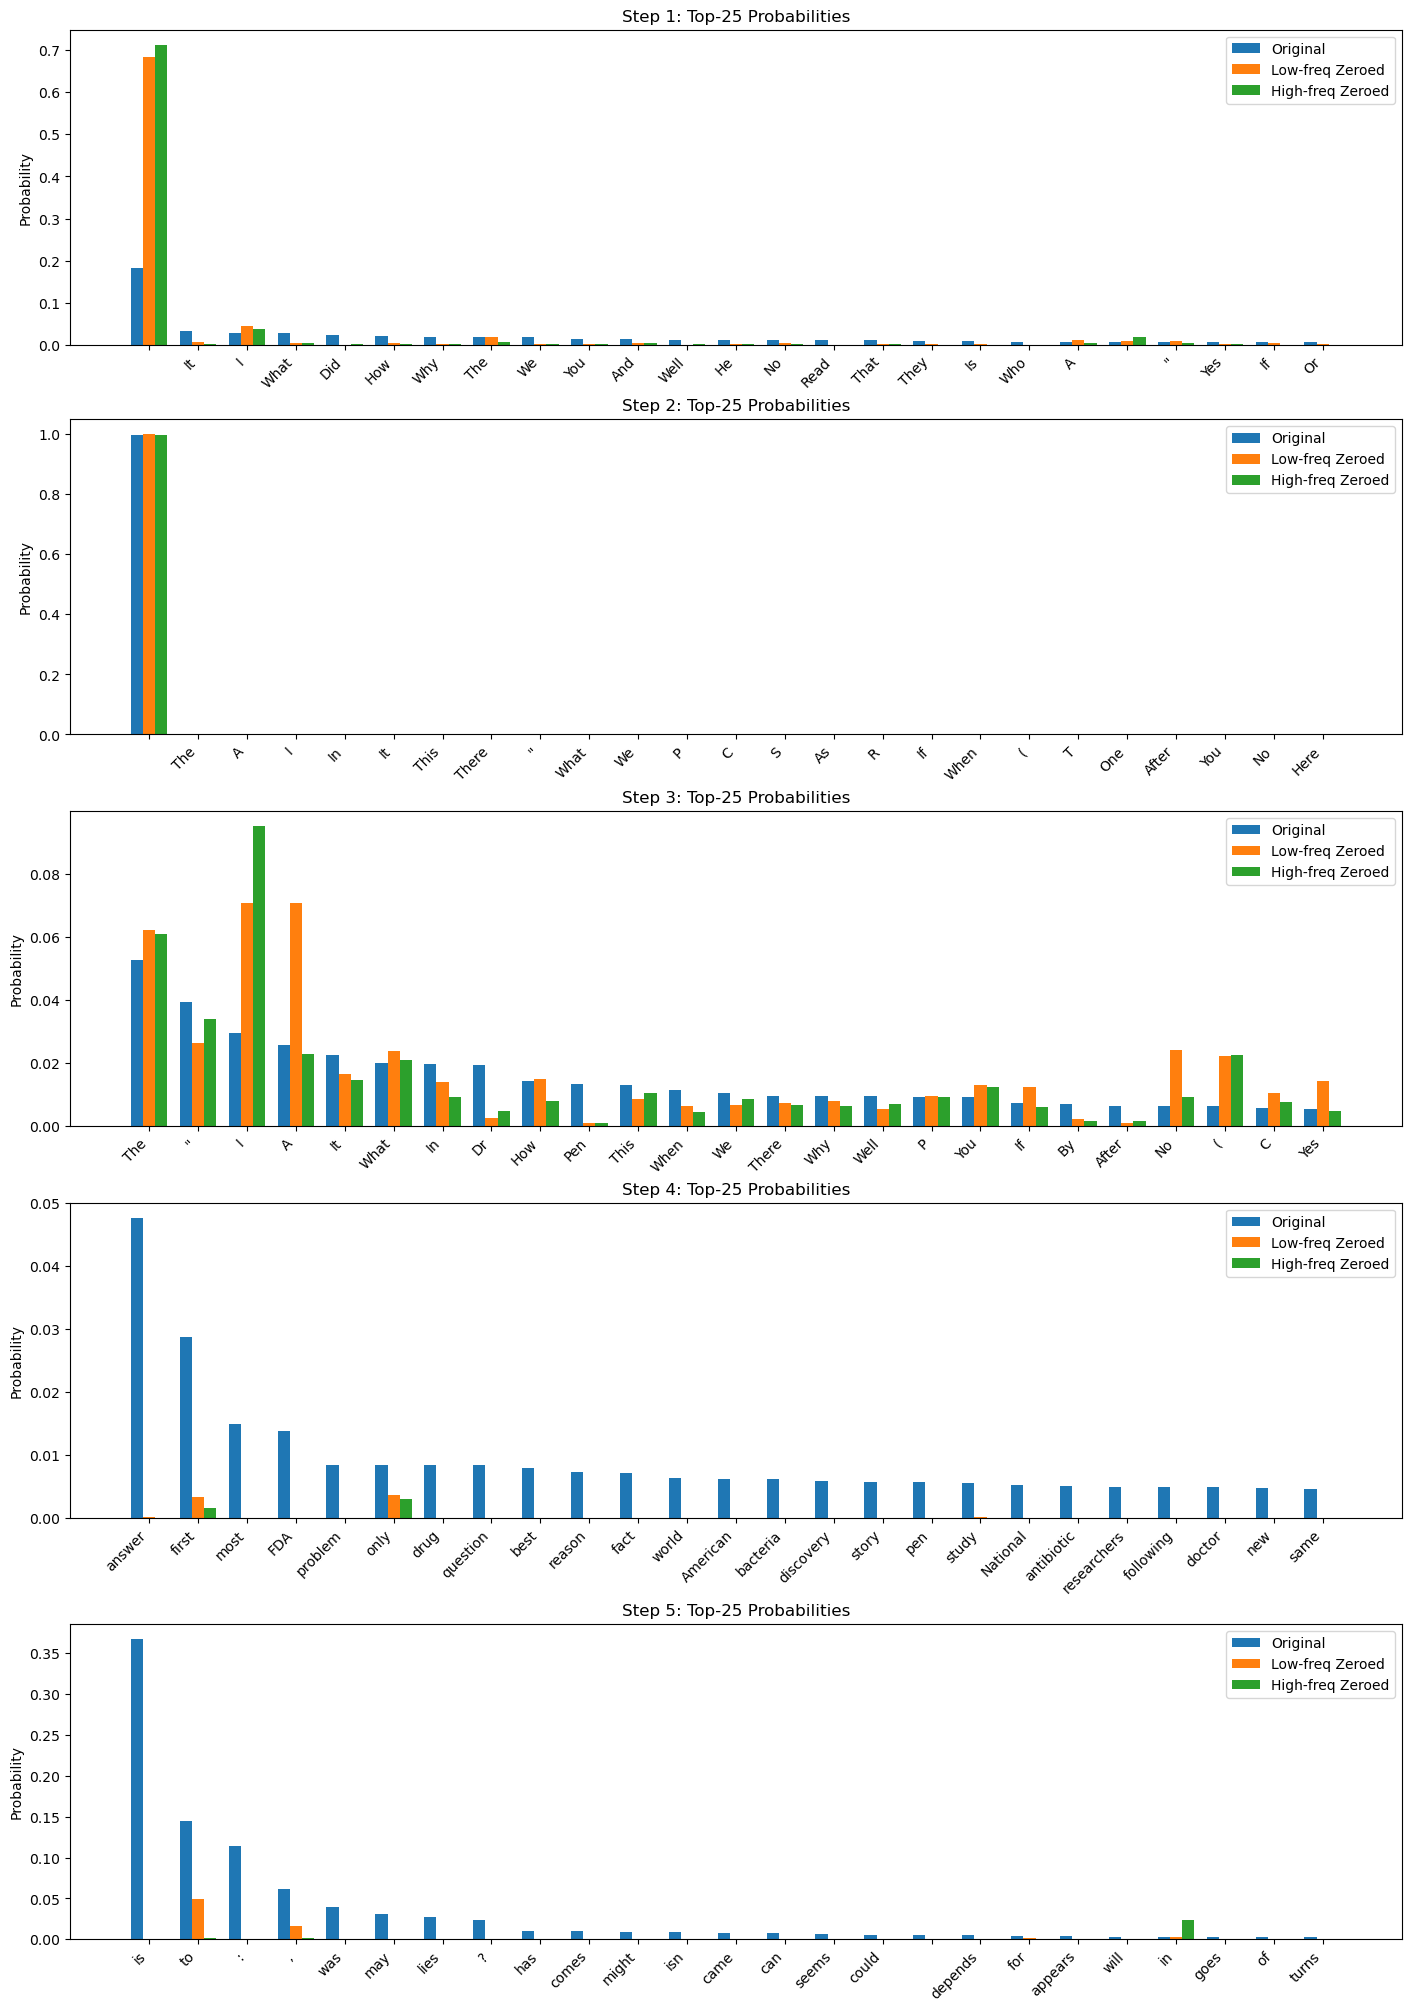

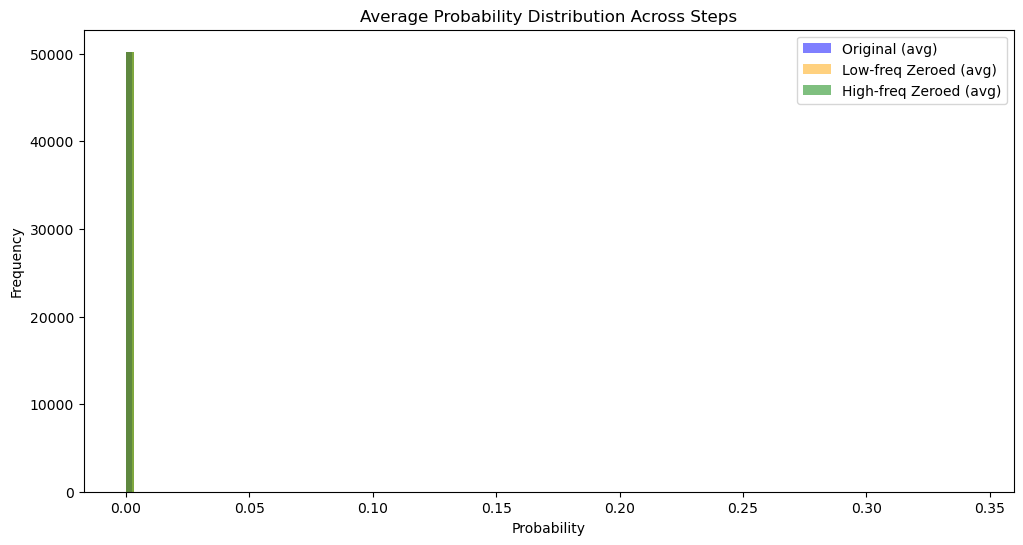

In [38]:
visualize_autoregressive_logits(
    results[0]["logits_original"], results[0]["logits_low"], results[0]["logits_high"], tokenizer, top_k=25
)